In [2]:
import os
from metrics import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nilmtk

from nilmtk import DataSet, MeterGroup
from nilmtk.datastore import HDFDataStore

# from MyDF import MyChunk
from MyDataSet import MyChunk
with torch.no_grad():
    torch.cuda.empty_cache() 

# DataLoader

In [4]:
SAMPLE_PERIOD = 60

In [5]:
sample_period = SAMPLE_PERIOD
d_name = 'UKDALE'
device = 'fridge'
path = '/mnt/B40864F10864B450/WorkSpace/PHD/PHD_exps/data/{}/{}.h5'.format(d_name,d_name)
dates = ["2013-08-01","2014-01-01"]
building = 1
train_dataset = MyChunk(path=path, building=building, window_size=50,
                  device=device, dates=dates, sample_period=sample_period, test=True)
train_loader = DataLoader(train_dataset, batch_size=1024, 
                          shuffle=False, num_workers=8)

Implementation of torch dataset using NILMTK


/home/nick/anaconda3/envs/pytorch_nilm/lib/python3.8/site-packages/nilmtk/utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
<ipython-input-5-868d4456ac2c>:8: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  train_dataset = MyChunk(path=path, building=building, window_size=50,


# Test loader

In [7]:
d_name = 'UKDALE'
# device = 'kettle'
device = 'fridge'
path = '/mnt/B40864F10864B450/WorkSpace/PHD/PHD_exps/data/{}/{}.h5'.format(d_name,d_name)
dates = ["2014-01-01", "2014-02-01"]
building = 1
window_size = 50
test_dataset = MyChunk(path=path, building=building, window_size=window_size,
                  device=device, dates=dates, test=True, mmax=train_dataset.mmax, sample_period=sample_period)
test_loader = DataLoader(test_dataset, batch_size=1024, 
                          shuffle=False, num_workers=8)

Implementation of torch dataset using NILMTK


/home/nick/anaconda3/envs/pytorch_nilm/lib/python3.8/site-packages/nilmtk/utils.py:502: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
<ipython-input-7-d5bdf8bf9fe7>:8: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  test_dataset = MyChunk(path=path, building=building, window_size=window_size,


# Import Models

In [10]:
from models import S2P, WGRU
from pytorch_lightning import Trainer

Global seed set to 42


Device: cuda:0


## Train model

In [11]:
# trainer = Trainer(fast_dev_run=True)
trainer = Trainer(gpus=1,max_epochs=5)
model = S2P(dropout=0.000)
# model = WGRU(dropout=0.000)
trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
/home/nick/anaconda3/envs/pytorch_nilm/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | output | Linear     | 1.0 K 
1 | conv   | Sequential | 47.1 K
2 | dense  | _Dense     | 2.6 M 
--------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.437    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/nick/anaconda3/envs/pytorch_nilm/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

## Inference

In [12]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/mnt/B40864F10864B450/WorkSpace/PHD/PHD_exps/NewPaper/torch_nilm/models.py:91: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, y)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_loss': 9.65870640357025e-05}
--------------------------------------------------------------------------------


/mnt/B40864F10864B450/WorkSpace/PHD/PHD_exps/NewPaper/torch_nilm/models.py:91: UserWarning: Using a target size (torch.Size([559])) that is different to the input size (torch.Size([559, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs, y)


[{'val_loss': 9.65870640357025e-05}]

# Results

In [13]:
preds = model.final_preds
print(preds.shape)

(44591,)


In [41]:
print(test_dataset.meterchunk.shape)

(44591,)


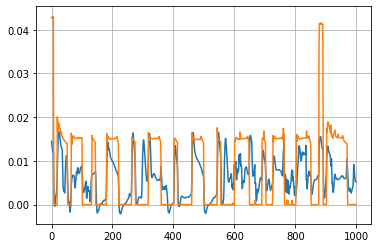

In [43]:
plt.plot(preds[:1000])
plt.plot(test_dataset.meterchunk[:1000])
plt.grid()

In [35]:
metrics(pred=preds, ground=test_dataset.meterchunk, mmax=train_dataset.mmax)

12211 23690 3429 5261


{'recall': 0.699,
 'precision': 0.781,
 'f1': 0.738,
 'accuracy': 0.805,
 'MAE': 26.574,
 'RETE': 0.186}